# Anomaly Detection with LSTM in Keras

Predict Anomalies using Confidence Intervals
https://towardsdatascience.com/anomaly-detection-with-lstm-in-keras-8d8d7e50ab1b

Detection of anomaly is useful in every business and the difficultness to detect these observations depends on the field of applications. If you are engaged in a problem of anomaly detection, which involves human activities (like prediction of sales or demand), you can take advantages from fundamental assumptions of human behaviors and plan a more efficient solution.
We try to predict the Taxi demand in NYC in a critical time period. We formulate easy and important assumptions about human behaviors, which will permit us to detect an easy solution to forecast anomalies. All the dirty job is made by a loyalty LSTM, developed in Keras, which makes predictions and detection of anomalies at the same time!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import tqdm
import random
import datetime
from sklearn.metrics import mean_squared_log_error

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow.keras.backend as K

import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline

## THE DATASET

I took the dataset for our analysis from [Numenta](https://numenta.org/) community. In particular I chose the [NYC Taxi Dataset](https://github.com/numenta/NAB/blob/master/data/realKnownCause/nyc_taxi.csv). This dataset shows the NYC taxi demand from 2014–07–01 to 2015–01–31 with an observation every half hour.

In [2]:
### READ DATA
df = pd.read_csv('../dataset/nyc_taxi.csv',index_col='timestamp')

# Converting the index as date
df.index = pd.to_datetime(df.index)

### CREATE FEATURES FOR year, month, day, hour ###
df['yr'] = df.index.year
df['mt'] = df.index.month
df['d'] = df.index.day
df['H'] = df.index.hour

print(df.shape)
df.head()

(10320, 5)


,value,yr,mt,d,H
timestamp,,,,,
2014-07-01 00:00:00,10844,2014,7,1,0
2014-07-01 00:30:00,8127,2014,7,1,0
2014-07-01 01:00:00,6210,2014,7,1,1
2014-07-01 01:30:00,4656,2014,7,1,1
2014-07-01 02:00:00,3820,2014,7,1,2


In this period 5 anomalies are present, in terms of deviation from normal behavior. They occur respectively during the 
- NYC marathon, 
- Thanksgiving, 
- Christmas, 
- New Year’s day, and a 
- snowstorm.

### Exemple of Weekly NORMAL observations

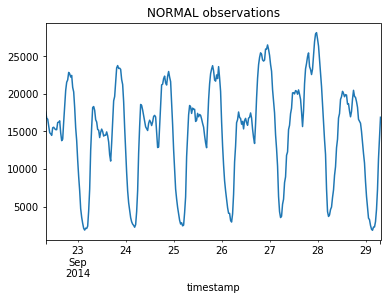

In [3]:
### PLOT SAMPLE OF DATA ###
df.iloc[4000:4000+7*48,:].value.plot(title='NORMAL observations');

### NYC Marathon

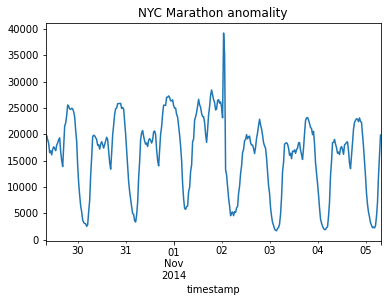

In [4]:
### PLOT SAMPLE OF DATA ###
df.iloc[4000+37*48:4000+37*48+7*48,:].value.plot(title='NYC Marathon anomality');

### Christmas

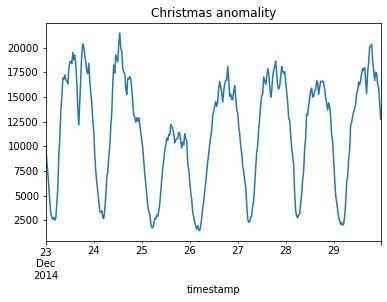

In [5]:
### PLOT SAMPLE OF DATA ###
df.iloc[8400:8400+7*48,:].value.plot(title='Christmas anomality');

### Anormality (outlier) detection:
The objective is to learn what "normal" data look like, and then use that to detect abnormal instances, such as new trends in the time series.

Our purpose is to detect these abnormal observetions in advance!

The first consideration we noticed, looking at the data, is the presence of an obvious daily pattern (during the day the demand is higher than night hours). The taxi demand seems to be driven also by a weekly trend: in certain days of the week the taxi demand is higher than others. We simply prove this computing autocorrelation.

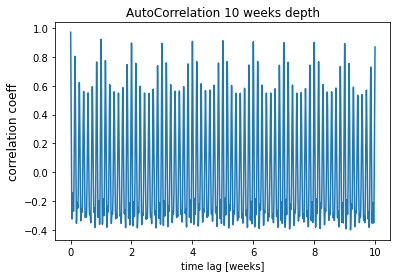

In [6]:
### WEEKLY AUTOCORR PLOT (10 WEEKS DEPTH) ###
timeLags = np.arange(1,10*48*7)
autoCorr = [df.value.autocorr(lag=dt) for dt in timeLags]

plt.plot(1.0/(48*7)*timeLags, autoCorr);
plt.xlabel('time lag [weeks]'); plt.ylabel('correlation coeff', fontsize=12);
plt.title('AutoCorrelation 10 weeks depth')
plt.show()

What we can do now is to take note of this important behaviours for our further analysis. I compute and store the means for every days of the weeks at every hours. This will be useful when we’ll standardized the data to build our model in order to reduce every kind of temporal dependency (I compute the means for the first 5000 observations that will become our future train set).

## THE MODEL

We need a strategy to detect outliers in advance. To do this, we decided to care about taxi demand predictions. We want to develop a model which is able to forecast demand taking into account uncertainty. One way to do this is to develop [quantile regression](https://en.wikipedia.org/wiki/Quantile_regression). 

### Quantile Regression

Let’s examine the python [statsmodels example for QuantReg](https://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html), which takes a look at the relationship between income and expenditures on food for a sample of working class Belgian households in 1857 [Engel], and see what kind of statistical analysis we can do.

We first need to load some modules and to retrieve the data. Conveniently, the Engel dataset is shipped with statsmodels.

In [7]:
data = sm.datasets.engel.load_pandas().data
data.head()

,income,foodexp
0,420.157651,255.839425
1,541.411707,310.958667
2,901.157457,485.680014
3,639.080229,402.997356
4,750.875606,495.560775


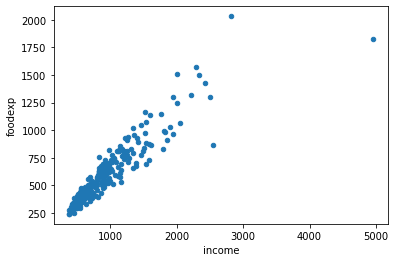

In [8]:
data.plot.scatter(x='income',y='foodexp');

#### Least Absolute Deviation (LAD)

The LAD model is a special case of quantile regression where $q=0.5$.

                         QuantReg Regression Results                          
Dep. Variable:                foodexp   Pseudo R-squared:               0.6206
Model:                       QuantReg   Bandwidth:                       64.51
Method:                 Least Squares   Sparsity:                        209.3
Date:                Thu, 08 Apr 2021   No. Observations:                  235
Time:                        20:58:55   Df Residuals:                      233
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     81.4823     14.634      5.568      0.000      52.649     110.315
income         0.5602      0.013     42.516      0.000       0.534       0.586

The condition number is large, 2.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.


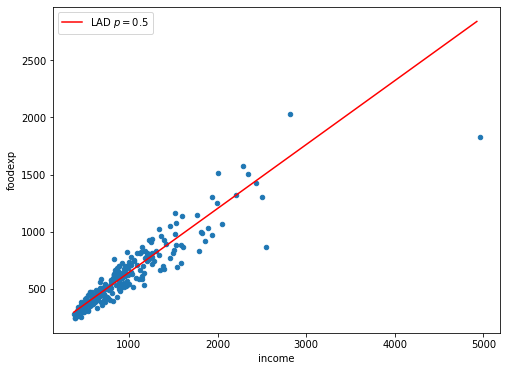

In [9]:
mod = smf.quantreg('foodexp ~ income', data)
res = mod.fit(q=.5)
print(res.summary())
print('Parameters: ', res.params)
print('R2: ', res.rsquared)

# plot
x = np.arange(data.income.min(), data.income.max(), 50)
get_y = lambda a, b: a + b * x

y = get_y(res.params['Intercept'], res.params['income'])

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y, color='red', label='LAD $p=0.5$')
ax.legend()
data.plot.scatter(x='income',y='foodexp',ax=ax);
plt.show()

We estimate the quantile regression model for many quantiles between .05 and .95, and compare best fit line from each of these models to Ordinary Least Squares results. 

               a         b        lb        ub
q                                             
0.05  124.880099  0.343361  0.268632  0.418090
0.20  102.313884  0.446900  0.408392  0.485407
0.35  105.841294  0.488901  0.457759  0.520043
0.50   81.482256  0.560181  0.534222  0.586139
0.65   74.033434  0.604576  0.582169  0.626982
0.80   58.006660  0.659511  0.639399  0.679622
0.95   64.103964  0.709069  0.687831  0.730306


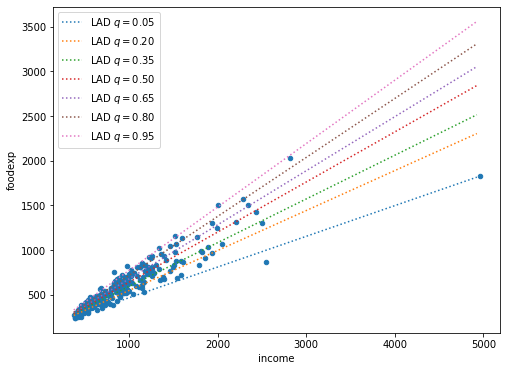

In [10]:
quantiles = np.arange(.05, .96, .15)
def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params['Intercept'], res.params['income']] + \
            res.conf_int().loc['income'].tolist()

models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=['q', 'a', 'b', 'lb', 'ub'])
models = models.set_index('q')
print(models)

# plot
x = np.arange(data.income.min(), data.income.max(), 50)
get_y = lambda a, b: a + b * x

fig, ax = plt.subplots(figsize=(8, 6))

for i in quantiles:
    y = get_y(models.a[i], models.b[i])
    ax.plot(x, y, linestyle='dotted', label='LAD $q={:.2f}$'.format(i))

ax.legend()
data.plot.scatter(x='income',y='foodexp',ax=ax);
plt.show()

#### Ordinary Least Squares (OLS)

[OLS](https://en.wikipedia.org/wiki/Ordinary_least_squares) is a type of linear least squares method for estimating the unknown parameters in a linear regression model.

**Principle of least squares**: minimizing the sum of the squares of the differences between the observed dependent variable $Y$ and those predicted by the linear function of the independent variable $X$.

                            OLS Regression Results                            
Dep. Variable:                foodexp   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     1141.
Date:                Thu, 08 Apr 2021   Prob (F-statistic):           9.92e-92
Time:                        20:58:56   Log-Likelihood:                -1445.7
No. Observations:                 235   AIC:                             2895.
Df Residuals:                     233   BIC:                             2902.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    147.4754     15.957      9.242      0.0

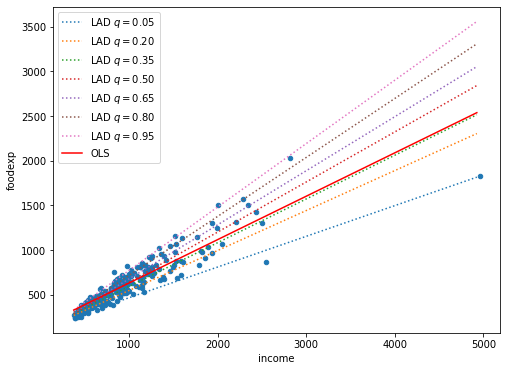

In [11]:
mod=smf.ols('foodexp ~ income', data)
res=mod.fit()
print(res.summary())
print('Parameters: ', res.params)
print('Limits: ', res.conf_int().loc['income'].tolist())
print('R2: ', res.rsquared)

# plot
x = np.arange(data.income.min(), data.income.max(), 50)
get_y = lambda a, b: a + b * x

fig, ax = plt.subplots(figsize=(8, 6))
for i in quantiles:
    y = get_y(models.a[i], models.b[i])
    ax.plot(x, y, linestyle='dotted', label='LAD $q={:.2f}$'.format(i))

y = get_y(res.params['Intercept'], res.params['income'])

ax.plot(x, y, color='red', label='OLS')
ax.legend()
data.plot.scatter(x='income',y='foodexp',ax=ax);
plt.show()

**note**: LAD for $q=0.5$ and OLS are not the same. The first can be interpreted as the median and the second as the mean. 

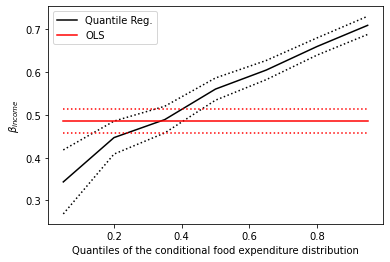

In [12]:
n = models.shape[0]
p1 = plt.plot(models.index, models.b, color='black', label='Quantile Reg.')
p2 = plt.plot(models.index, models.ub, linestyle='dotted', color='black')
p3 = plt.plot(models.index, models.lb, linestyle='dotted', color='black')
p4 = plt.plot(models.index, [res.params['income']] * n, color='red', label='OLS')
p5 = plt.plot(models.index, [res.conf_int().loc['income'].tolist()[0]] * n, linestyle='dotted', color='red')
p6 = plt.plot(models.index, [res.conf_int().loc['income'].tolist()[1]] * n, linestyle='dotted', color='red')
plt.ylabel(r'$\beta_{income}$')
plt.xlabel('Quantiles of the conditional food expenditure distribution')
plt.legend()
plt.show()

The dotted black lines form 95% point-wise confidence band around 10 quantile regression estimates (solid black line). The red lines represent OLS regression results along with their 95% confidence interval.

In most cases, the quantile regression point estimates lie outside the OLS confidence interval, which suggests that the effect of income on food expenditure may not be constant across the distribution.

#### [Deep Quantile Regression](https://github.com/sachinruk/KerasQuantileModel/blob/master/Keras%20Quantile%20Model.ipynb)

One area that Deep Learning has not explored extensively is the uncertainty in estimates. However, as far as decision making goes, most people actually require quantiles as opposed to true uncertainty in an estimate. eg. For a given age the weight of an individual will vary. What would be interesting is the (for arguments sake) the 10th and 90th percentile. The uncertainty of the estimate of an individuals weight is less interesting.

Standardise the inputs and outputs so that it is easier to train. I have't saved the mean and standard deviations, but you should.

In [13]:
data['income_st']= (data.income - data.income.mean())/data.income.std()
data['foodexp_st']= (data.foodexp - data.foodexp.mean())/data.foodexp.std()
data

,income,foodexp,income_st,foodexp_st
0,420.157651,255.839425,-1.082978,-1.332253
1,541.411707,310.958667,-0.849451,-1.132876
2,901.157457,485.680014,-0.156608,-0.500874
3,639.080229,402.997356,-0.661349,-0.799954
4,750.875606,495.560775,-0.446039,-0.465133
...,...,...,...,...
230,440.517424,306.519079,-1.043766,-1.148935
231,541.200597,299.199328,-0.849858,-1.175412
232,581.359892,468.000798,-0.772514,-0.564823
233,743.077243,522.601906,-0.461058,-0.367320


In [14]:
model = Sequential()
model.add(Dense(units=10, input_dim=1,activation='relu'))
model.add(Dense(units=10, input_dim=1,activation='relu'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adadelta')
model.fit(data.income_st.values, data.foodexp_st.values, epochs=50000, batch_size=32, verbose=0)
model.evaluate(data.income_st.values, data.foodexp_st.values)

8/8 [==============================] - 0s 4ms/step - loss: 0.2606


0.2605687081813812

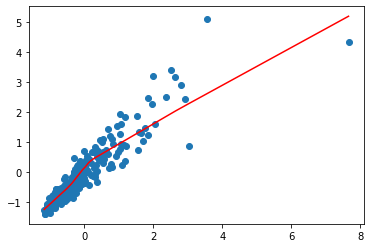

In [15]:
t_test = np.linspace(data.income_st.min(),data.income_st.max(),200)
y_test = model.predict(t_test)

plt.scatter(data.income_st,data.foodexp_st)
plt.plot(t_test, y_test,'r')
plt.show()

##### Quantile Regression Loss function

In regression the most commonly used loss function is the mean squared error function. If we were to take the negative of this loss and exponentiate it, the result would correspond to the gaussian distribution. The mode of this distribution (the peak) corresponds to the mean parameter. Hence, when we predict using a neural net that minimised this loss we are predicting the mean value of the output which may have been noisy in the training set.

The loss in Quantile Regression for an individual data point is defined as: 

$$
\begin{align}
\mathcal{L}(\xi_i|\alpha)=\begin{cases}
\alpha \xi_i &amp;\text{if }\xi_i\ge 0, \\
(\alpha-1) \xi_i &amp;\text{if }\xi_i<0.
\end{cases}
\end{align}
$$ 

where $\alpha$ is the required quantile (a value between 0 and 1) and $\xi_i = y_i - f(\mathbf{x}_i)$ and, $f(\mathbf{x}_i)$ is the predicted (quantile) model and $y$ is the observed value for the corresponding input $x$. The final overall loss is defines as: 

$$
\mathcal{L}(\mathbf{y},\mathbf{f}|\alpha)=\frac{1}{N} \sum_{i=1}^N \mathcal{L}(y_i-f(\mathbf{x}_i)|\alpha)
$$

If we were to take the negative of the individual loss and exponentiate it, we get the distribution know as the Asymmetric Laplace distribution, shown below. The reason that this loss function works is that if we were to find the area under the graph to the left of zero it would be alpha, the required quantile.

https://miro.medium.com/max/700/1*gUrYM90-7NNKwYO6-ONc5A.png

The following function defines the loss function for a quantile model.
Note: The following 4 lines is ALL that you change in comparison to a normal Deep Learning method, i.e. The loss function is all that changes.

In [16]:
def tilted_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

In [17]:
def engelModel():
    model = Sequential()
    model.add(Dense(units=10, input_dim=1,activation='relu'))
    model.add(Dense(units=10, input_dim=1,activation='relu'))
    model.add(Dense(1))
    
    return model

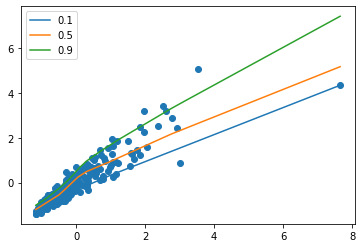

In [18]:
qs = [0.1, 0.5, 0.9]

t_test = np.linspace(data.income_st.min(),data.income_st.max(),200)
plt.scatter(data.income_st,data.foodexp_st)

for q in qs:
    model = engelModel()
    model.compile(loss=lambda y,f: tilted_loss(q,y,f), optimizer='adadelta')
    model.fit(data.income_st.values, data.foodexp_st.values, epochs=50000, batch_size=32, verbose=0)
    
    # Predict the quantile
    y_test = model.predict(t_test)
    plt.plot(t_test, y_test, label=q) # plot out this quantile

plt.legend()    
plt.show()


##### Final Notes

1. Note that the quantile 0.5 is the same as median, which you can attain by minimising Mean Absolute Error, which you can attain in Keras regardless with loss='mae'.
2. Uncertainty and quantiles are not the same thing. But most of the time you care about quantiles and not uncertainty.
3. If you really do want uncertainty with deep nets checkout http://mlg.eng.cam.ac.uk/yarin/blog_3d801aa532c1ce.html

*** back to the outlyer detection Model ***

We focus on predictions of extreme values: lower (10th quantile), upper (90th quantile) and the classical 50th quantile. Computing also the 90th and 10th quantile we cover the most likely values the reality can assume. The width of this range can be very depth; we know that it is small when our model is sure about the future and it can be huge when our model isn’t able to see important changes in the domain of interest. We took advantage from this behaviour and let our model says something about outliers detection in the field of taxi demand preditcion. We are expecting to get a tiny interval (90–10 quantile range) when our model is sure about the future because it has all under control; on the other hand we are expecting to get an anomaly when the interval becomes bigger. This is possible because our model isn’t trained to handle this kind of scenario which can results in anomaly.

We make all this magic reality building a simple LSTM Neural Network in Keras. Our model will receive as input the past observations. We resize our data for feeding our LSTM with daily window size (48 observations: one observation for every half hour). When we were generating data, as I cited above, we operated logarithmic transformation and standardization subtracting the mean daily hour values, in order to see an observation as the logarithmic variation from its daily mean hour value. We build our target variables in the same way with half hour shifting (we want to predict the demand values for the next thirty minutes).

In [19]:
### CREATE WEEKDAY FEATURE AND COMPUTE THE MEAN FOR WEEKDAYS AT EVERY HOURS ###

df['weekday'] = df.index.weekday 
df['weekday_hour'] = df.weekday.astype(str) +' '+ df.H.astype(str)
df['m_weekday'] = df.weekday_hour.replace(df[:5000].groupby('weekday_hour')['value'].mean().to_dict())
df

,value,yr,mt,d,H,weekday,weekday_hour,m_weekday
timestamp,,,,,,,,
2014-07-01 00:00:00,10844,2014,7,1,0,1,1 0,8774.433333
2014-07-01 00:30:00,8127,2014,7,1,0,1,1 0,8774.433333
2014-07-01 01:00:00,6210,2014,7,1,1,1,1 1,5242.933333
2014-07-01 01:30:00,4656,2014,7,1,1,1,1 1,5242.933333
2014-07-01 02:00:00,3820,2014,7,1,2,1,1 2,3170.433333
...,...,...,...,...,...,...,...,...
2015-01-31 21:30:00,24670,2015,1,31,21,5,5 21,21298.033333
2015-01-31 22:00:00,25721,2015,1,31,22,5,5 22,23126.666667
2015-01-31 22:30:00,27309,2015,1,31,22,5,5 22,23126.666667


In [20]:
### CREATE GENERATOR FOR LSTM ###
sequence_length = 48

def gen_index(id_df, seq_length, seq_cols):

    data_matrix =  id_df[seq_cols]
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length, 1), range(seq_length, num_elements, 1)):
        
        yield data_matrix[stop-sequence_length:stop].values.reshape((-1,len(seq_cols)))

In [21]:
### CREATE AND STANDARDIZE DATA FOR LSTM ### 
cnt, mean = [], []
for sequence in gen_index(df, sequence_length, ['value']):
    cnt.append(sequence)
    
for sequence in gen_index(df, sequence_length, ['m_weekday']):
    mean.append(sequence)

cnt, mean = np.log(cnt), np.log(mean)
cnt = cnt - mean
cnt.shape

(10272, 48, 1)

In [22]:
### CREATE AND STANDARDIZE LABEL FOR LSTM ###
init = df.m_weekday[sequence_length:].apply(np.log).values
label = df.value[sequence_length:].apply(np.log).values - init
label.shape

(10272,)

Operate quantile regression in Keras is very simple (I took inspiration from [this post](https://towardsdatascience.com/deep-quantile-regression-c85481548b5a)). We easily define the custom quantile loss function which penalizes errors based on the quantile and whether the error was positive (actual > predicted) or negative (actual < predicted). Our network has 3 outputs and 3 losses, one for every quantile we try to predict.

In [23]:
### DEFINE QUANTILE LOSS ###
def q_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

In [24]:
### TRAIN TEST SPLIT ###
X_train, X_test = cnt[:5000], cnt[5000:]
y_train, y_test = label[:5000], label[5000:]
train_date, test_date = df.index.values[sequence_length:5000+sequence_length], df.index.values[5000+sequence_length:]

In [25]:
tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

### CREATE MODEL ###
losses = [lambda y,f: q_loss(0.1,y,f), lambda y,f: q_loss(0.5,y,f), lambda y,f: q_loss(0.9,y,f)]

inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
lstm = Bidirectional(LSTM(64, return_sequences=True, dropout=0.3))(inputs, training = True)
lstm = Bidirectional(LSTM(16, return_sequences=False, dropout=0.3))(lstm, training = True)
dense = Dense(50)(lstm)
out10 = Dense(1)(dense)
out50 = Dense(1)(dense)
out90 = Dense(1)(dense)
model = Model(inputs, [out10,out50,out90])

model.compile(loss=losses, optimizer='adam', loss_weights = [0.3,0.3,0.3])
model.fit(X_train, [y_train,y_train,y_train], epochs=50, batch_size=128, verbose=2)

Epoch 1/50
Cause: could not parse the source code of <function <lambda> at 0x14cd1a680>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names.
Match 0:
(lambda y, f: q_loss(0.1, y, f))

Match 1:
(lambda y, f: q_loss(0.5, y, f))

Match 2:
(lambda y, f: q_loss(0.9, y, f))

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x14cd1a680>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names.
Match 0:
(lambda y, f: q_loss(0.1, y, f))

Match 1:
(lambda y, f: q_loss(0.5, y, f))

Match 2:
(lambda y, f: q_loss(0.9, y, f))

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <functi

Epoch 45/50
40/40 - 3s - loss: 0.0169 - dense_13_loss: 0.0141 - dense_14_loss: 0.0289 - dense_15_loss: 0.0134
Epoch 46/50
40/40 - 3s - loss: 0.0169 - dense_13_loss: 0.0140 - dense_14_loss: 0.0288 - dense_15_loss: 0.0135
Epoch 47/50
40/40 - 3s - loss: 0.0165 - dense_13_loss: 0.0138 - dense_14_loss: 0.0284 - dense_15_loss: 0.0130
Epoch 48/50
40/40 - 3s - loss: 0.0167 - dense_13_loss: 0.0141 - dense_14_loss: 0.0286 - dense_15_loss: 0.0130
Epoch 49/50
40/40 - 3s - loss: 0.0166 - dense_13_loss: 0.0138 - dense_14_loss: 0.0285 - dense_15_loss: 0.0131
Epoch 50/50
40/40 - 3s - loss: 0.0168 - dense_13_loss: 0.0140 - dense_14_loss: 0.0286 - dense_15_loss: 0.0133


## CROSSOVER PROBLEM

When dealing with Neural Network in Keras, one of the tedious problem is the uncertainty of results due to the internal weigths initialization. With its formulation, our problem seems to particularly suffer of this kind of problem; i.e. computing quantile predictions we can’t permit quantiles overlapping, this not make sense! To avoid this pitfall I make use of bootstrapping in prediction phase: I reactivate dropout of my network (trainable: true in the model), iterate predition for 100 times, store them and finally calculate the desired quantiles (I make use of this clever technique also in this post).

In [26]:
### QUANTILEs BOOTSTRAPPING ###
pred_10, pred_50, pred_90 = [], [], []

for i in tqdm.tqdm(range(0,100)):
    
    predd = model.predict(X_test)
    pred_10.append(predd[0])
    pred_50.append(predd[1])
    pred_90.append(predd[2])

pred_10 = np.asarray(pred_10)[:,:,0] 
pred_50 = np.asarray(pred_50)[:,:,0]
pred_90 = np.asarray(pred_90)[:,:,0]

100%|██████████| 100/100 [02:43<00:00,  1.64s/it]


This process is graphically explained below with a little focus on a subset of predictions. Given quantile bootstraps, we calculated summary measures (red lines) of them, avoiding crossover.

In [27]:
### REVERSE TRANSFORM PREDICTIONS ###
pred_90_m = np.exp(np.quantile(pred_90,0.9,axis=0) + init[5000:])
pred_50_m = np.exp(pred_50.mean(axis=0) + init[5000:])
pred_10_m = np.exp(np.quantile(pred_10,0.1,axis=0) + init[5000:])

In [28]:
### EVALUATION METRIC ###
mean_squared_log_error(np.exp(y_test + init[5000:]), pred_50_m)

0.06907365954001285

## RESULTS

As I previously cited, I used the firstly 5000 observations for training and the remaining (around 5000) for testing.

Our model reaches a great performance forecasting taxi demand with the 50th quantile. Around 0.055 Mean Squared Log Error is a brilliant result! This means that the LSTM Network is able to understand the underling rules that drive taxi demand. So our approach for anomaly detection sounds great… We computed the difference among the 90th quantile predictions and 10th quantile predictions and see what’s appened.

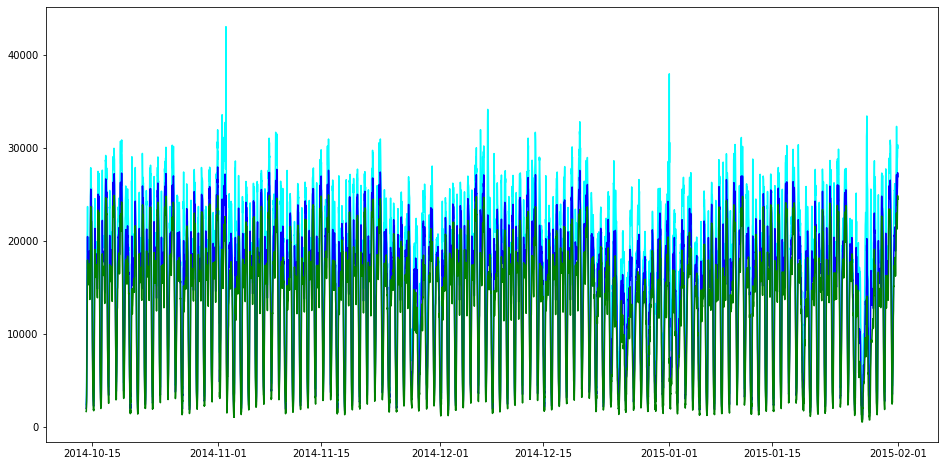

In [29]:
### PLOT QUANTILE PREDICTIONS ###
plt.figure(figsize=(16,8))
plt.plot(test_date, pred_90_m, color='cyan')
plt.plot(test_date, pred_50_m, color='blue')
plt.plot(test_date, pred_10_m, color='green')

### CROSSOVER CHECK ###
plt.scatter(np.where(np.logical_or(pred_50_m>pred_90_m, pred_50_m<pred_10_m))[0], 
            pred_50_m[np.logical_or(pred_50_m>pred_90_m, pred_50_m<pred_10_m)], c='red', s=50)

The quantile interval range (blue dots) is higher in period of uncertainty. In the other cases, the model tends to generalize well, as we expected. Going deeper, we start to investigate about these periods of high uncertainty. We noticed that these coincide with our initial assumptions. The orange circles plotted below are respectively: NYC marathon, Thanksgiving, Christmas, New Years day, and a snow storm.

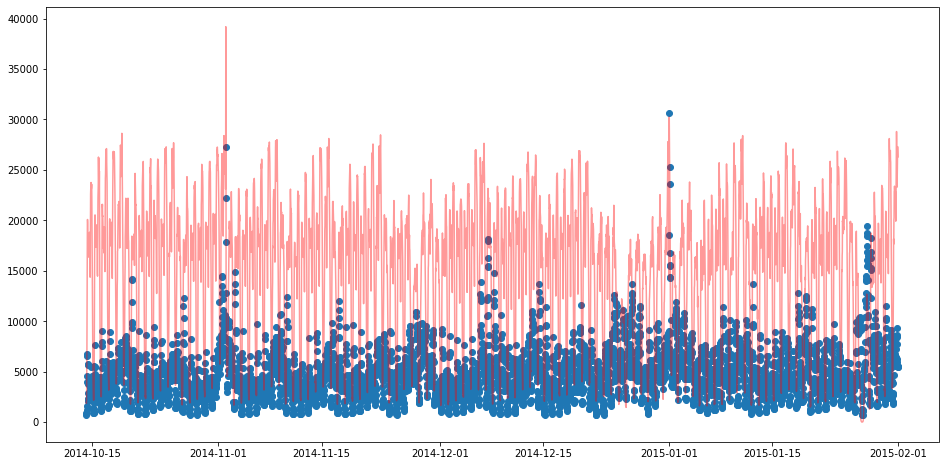

In [30]:
### PLOT UNCERTAINTY INTERVAL LENGHT WITH REAL DATA ###
plt.figure(figsize=(16,8))
plt.plot(test_date, np.exp(y_test + init[5000:]), color='red', alpha=0.4)
plt.scatter(test_date, pred_90_m - pred_10_m)

We can conclude that we reach our initial targets: achive a great forecating power and exploit the strength of our model to identificate uncertainty. We also make use of this to say something about anomalies detection.

## SUMMARY

Wereproduce a good solution for anomaly detection and forecasting. We make use of a LSTM Network to learn the behaviour of taxi demand in NYC. We utilized what we learned to make predition and estimate uncertainty at the same time. We implicitly define an anomaly as an unpredictable observation — i.e. with a great amout of uncertainty. This simple assumption permits to our LSTM to make all the work for us.